In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pandas as pd
import numpy as np

# Runtime plots

In [2]:
def get_run_data(res_dir):
    files = os.listdir(res_dir)
    res = {}
    for f in files:
        data = json.load(open(os.path.join(res_dir, f), 'r'))
        start = data['time_script_start']
        end = data['time_script_complete']
        res[int(f.split('_')[1])] = (end-start) /60
        
    res = pd.Series(res).sort_index()
    res.name = res_dir
    return res

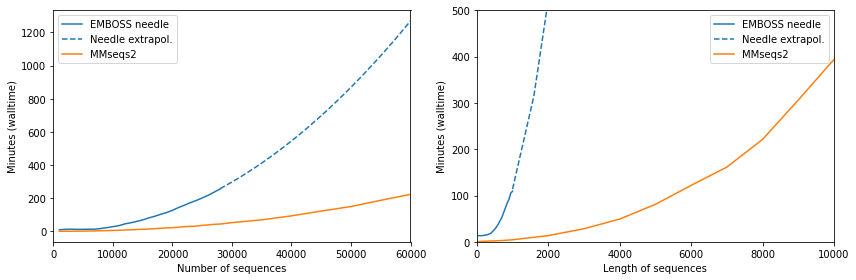

In [4]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
performance_needle = get_run_data('runtime_benchmark/needle_size_run1/')
performance_mmseqs2 = get_run_data('runtime_benchmark/mmseqs2_size_run1/')

poly = np.polynomial.Polynomial.fit(x = performance_needle.index, y=performance_needle, deg=2)
x, y = poly.linspace(100, [performance_needle.index.max(), 60000])

performance_needle.plot(label='EMBOSS needle')
prev_color = plt.gca().lines[-1].get_color()
pd.Series(y, index=x).plot(label='Needle extrapol.', linestyle='--', color = prev_color)
plt.xlabel('Number of sequences')
plt.ylabel('Minutes (walltime)')
performance_mmseqs2.plot(label='MMseqs2')
plt.legend()

#plt.xlim(0, 10000)
plt.xlim(0, 60000)

plt.subplot(1,2,2)

performance_needle = get_run_data('runtime_benchmark/needle_length_run1/')
performance_mmseqs2 = get_run_data('runtime_benchmark/mmseqs2_length_run1/')

poly = np.polynomial.Polynomial.fit(x = performance_needle.index, y=performance_needle, deg=2)
x, y = poly.linspace(100, [performance_needle.index.max(), 60000])

performance_needle.plot(label='EMBOSS needle')
prev_color = plt.gca().lines[-1].get_color()
pd.Series(y, index=x).plot(label='Needle extrapol.', linestyle='--', color = prev_color)

plt.xlabel('Length of sequences')
plt.ylabel('Minutes (walltime)')
performance_mmseqs2.plot(label='MMseqs2')
plt.legend()

plt.xlim(0, 10000)
plt.ylim(0, 500)

plt.tight_layout()
#plt.suptitle('Time complexity of Graph-Part')

# Partition quality plots

In [30]:
def add_counts_to_seaborn_plot(ax, df, separator='\n'):
    '''Add the observation counts to a seaborn violin plot/box plot'''
    dataframe_key = ax.get_ylabel()
    df[dataframe_key] = df[dataframe_key].astype(str)
    counts = df[dataframe_key].value_counts()
    new_ticks = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        n = counts.loc[label_text]
        new_ticks.append(label_text + separator + '('+str(n)+')')
        
    ax.set_yticklabels(new_ticks)

## Protein

In [8]:
def get_data_as_df(prefix, base_path='results/'):
    '''Get partitioning data as df for easy plotting.
    One row per sequence.
    variable	value	algorithm
    '''
    plot_dict = {'MMseqs2 Partitioning': f'{base_path}/{prefix}_partition_mmseqs2_cmode0_qc.csv',
             'MMseqs2 Reduction': f'{base_path}/{prefix}_reduction_mmseqs2_cmode0_qc.csv',
             'CD-HIT Partitioning': f'{base_path}/{prefix}_partition_cd_hit_qc.csv',
             'CD-HIT Reduction': f'{base_path}/{prefix}_reduction_cd_hit_qc.csv',
             'Graph-Part MMseqs2': f'{base_path}/{prefix}_partition_graphpart_mmseqs2_qc.csv',
             'Graph-Part needle': f'{base_path}/{prefix}_partition_graphpart_needle_qc.csv',
    }
    
    dfs = []
    for name, file in plot_dict.items():

        df = pd.read_csv(file)
        df_m = pd.melt(df, value_vars=['max_ident_other'])
        df_m['algorithm'] = name
        dfs.append(df_m)

    df = pd.concat(dfs)
    
    return df

In [55]:
PROPS = {
    #'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'fliersize':0.5,
    'width':0.7,
}

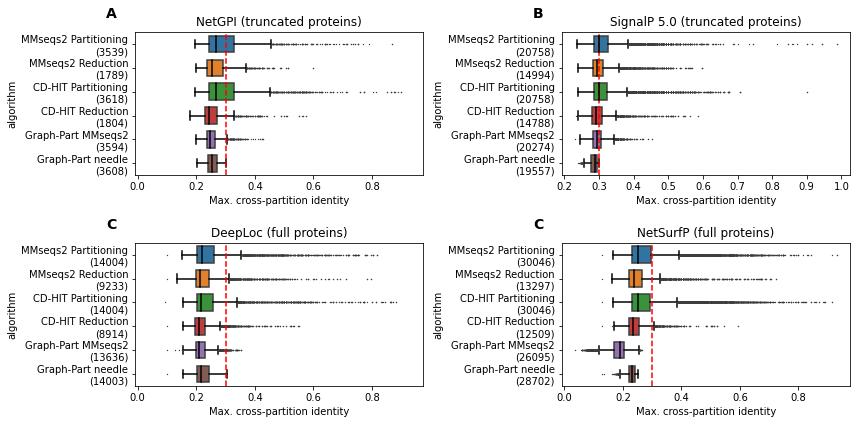

In [319]:
fig = plt.figure(figsize=(12,6))

with sns.axes_style(None):
    plt.subplot(2,2,1)
    df = get_data_as_df('netgpi')
    ax1 = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    add_counts_to_seaborn_plot(ax1, df)
    plt.axvline(0.3, linestyle='--', color='red')
    plt.title('NetGPI (truncated proteins)')
    plt.xlabel('Max. cross-partition identity')

    ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, 
            size=14, weight='bold')

    plt.subplot(2,2,2)
    df = get_data_as_df('signalp')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    add_counts_to_seaborn_plot(ax, df)
    plt.axvline(0.3, linestyle='--', color='red')
    plt.title('SignalP 5.0 (truncated proteins)')
    plt.xlabel('Max. cross-partition identity')
    
    ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
            size=14, weight='bold')

    plt.subplot(2,2,3, sharex=ax1)
    df = get_data_as_df('deeploc')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    add_counts_to_seaborn_plot(ax, df)
    plt.axvline(0.3, linestyle='--', color='red')
    plt.title('DeepLoc (full proteins)')
    plt.xlabel('Max. cross-partition identity')
    
    ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
            size=14, weight='bold')
    

    plt.subplot(2,2,4, sharex=ax1)
    df = get_data_as_df('netsurfp')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    add_counts_to_seaborn_plot(ax, df)
    plt.axvline(0.3, linestyle='--', color='red')
    plt.title('NetSurfP (full proteins)')
    plt.xlabel('Max. cross-partition identity')
    
    ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
            size=14, weight='bold')
    
    plt.tight_layout()

In [80]:
threshold = 0.3
overlap = {}
df = get_data_as_df('netgpi')
overlap['netgpi'] = df.groupby('algorithm').apply(lambda x: (x['value']>threshold).sum()/x.shape[0])
df = get_data_as_df('signalp')
overlap['signalp'] = df.groupby('algorithm').apply(lambda x: (x['value']>threshold).sum()/x.shape[0])
df = get_data_as_df('deeploc')
overlap['deeploc'] = df.groupby('algorithm').apply(lambda x: (x['value']>threshold).sum()/x.shape[0])

pd.DataFrame.from_dict(overlap).style.format('{:.2%}')

,netgpi,signalp,deeploc
algorithm,,,
CD-HIT Partitioning,32.09%,48.83%,12.23%
CD-HIT Reduction,13.97%,33.64%,4.97%
Graph-Part MMseqs2,5.84%,33.25%,0.92%
Graph-Part needle,0.00%,0.00%,0.01%
MMseqs2 Partitioning,33.06%,50.97%,14.54%
MMseqs2 Reduction,21.63%,39.72%,9.24%


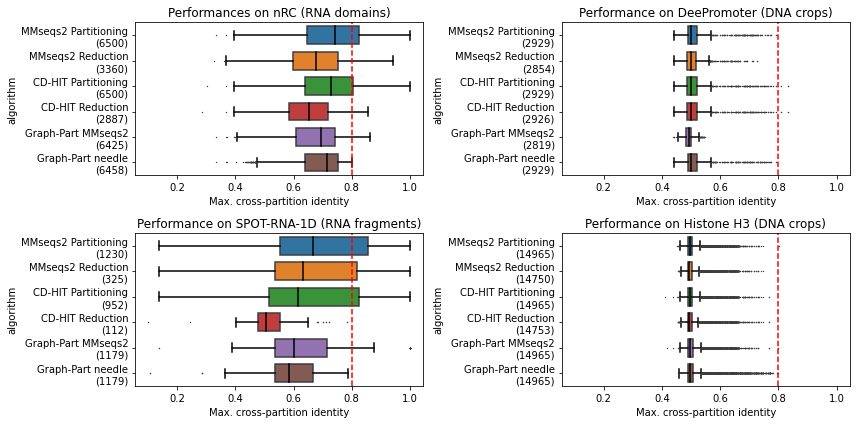

In [221]:
plt.figure(figsize=(12,6))

with sns.axes_style(None):
    plt.subplot(2,2,1)
    df = get_data_as_df('nrc')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    add_counts_to_seaborn_plot(ax, df)
    plt.axvline(0.8, linestyle='--', color='red')
    plt.title('Performances on nRC (RNA domains)')
    plt.xlabel('Max. cross-partition identity')


    plt.subplot(2,2,2, sharex=ax)
    df = get_data_as_df('deepromoter')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    add_counts_to_seaborn_plot(ax, df)
    plt.axvline(0.8, linestyle='--', color='red')
    plt.title('Performance on DeePromoter (DNA crops)')
    plt.xlabel('Max. cross-partition identity')


    plt.subplot(2,2,3, sharex=ax)
    df = get_data_as_df('spotrna1d')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    add_counts_to_seaborn_plot(ax, df)
    plt.axvline(0.8, linestyle='--', color='red')
    plt.title('Performance on SPOT-RNA-1D (RNA fragments)')
    plt.xlabel('Max. cross-partition identity')
    

    plt.subplot(2,2,4, sharex=ax)
    df = get_data_as_df('histone')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    add_counts_to_seaborn_plot(ax, df)
    plt.axvline(0.8, linestyle='--', color='red')
    plt.title('Performance on Histone H3 (DNA crops)')
    plt.xlabel('Max. cross-partition identity')

    plt.tight_layout()

In [314]:
hobohm_dict = {}
graphpart_dict = {}
for fname in os.listdir('hobohm_benchmark/'):
    num_lines = sum(1 for line in open(os.path.join('hobohm_benchmark',fname)))
    if fname.startswith('graphpart'):
        graphpart_dict[int(fname.split('_')[1].rstrip('.csv'))] = num_lines
    elif fname.startswith('hobohm'):
        hobohm_dict[int(fname.split('_')[1].rstrip('.txt'))] = num_lines

In [315]:
df = pd.DataFrame.from_dict([hobohm_dict, graphpart_dict]).T
df.columns=['Hobohm', 'Graph-Part']
df = df.sort_index()

In [316]:
df

,Hobohm,Graph-Part
10,26.0,NaN
15,70.0,NaN
18,202.0,700.0
19,290.0,809.0
20,426.0,981.0
21,590.0,1249.0
22,821.0,1691.0
23,1020.0,2160.0
24,1195.0,2953.0
25,1341.0,3235.0


Text(0.5, 0, 'Percent identity threshold')

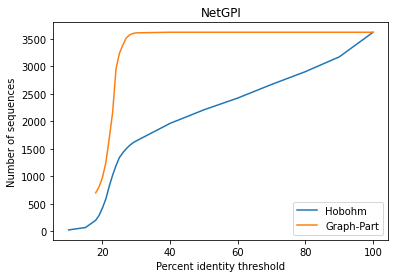

In [318]:
df.plot(title='NetGPI')
plt.ylabel('Number of sequences')
plt.xlabel('Percent identity threshold')
# plt.axvline(20, linestyle='--', color='orange')